# Portfolio Analysis of Energy sector

### Stocks under observation:

    - Phillips 66 (NYSE:PSX) 
    - Valero Energy (NYSE:VLO)
    - Enterprise Products Partners (NYSE:EPD)
    - Clearway Energy (NYSE:CWEN)
    - Vivint Solar (NYSE:VSLR)
    - SolarEdge Technologies (NASDAQ:SEDG)


In [12]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as wb
import scipy.optimize as sco
import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Pulling stock data 

In [13]:
energy = ['PSX', 'VLO', 'EPD', 'CWEN','VSLR', 'SEDG' ]
data = pd.DataFrame()
for i in range(len(energy)):
    
    df = wb.DataReader(energy[i], data_source='yahoo', start='2019-1-1', end = '2020-5-1')
    df['stock'] = energy[i]
    data = data.append(df[['Adj Close', 'stock']])

table = data.pivot(columns='stock')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head()

,CWEN,EPD,PSX,SEDG,VLO,VSLR
Date,,,,,,
2019-01-02,16.227438,22.501736,83.155182,36.150002,70.506401,3.84
2019-01-03,16.038748,22.915936,82.003922,35.500000,69.237381,3.73
2019-01-04,16.633125,23.870390,85.721931,37.250000,71.859436,3.96
2019-01-07,15.963269,24.419651,86.316437,35.009998,71.934082,4.07
2019-01-08,15.076422,24.779821,86.240944,35.000000,72.186028,3.90


Text(0, 0.5, 'price in $')

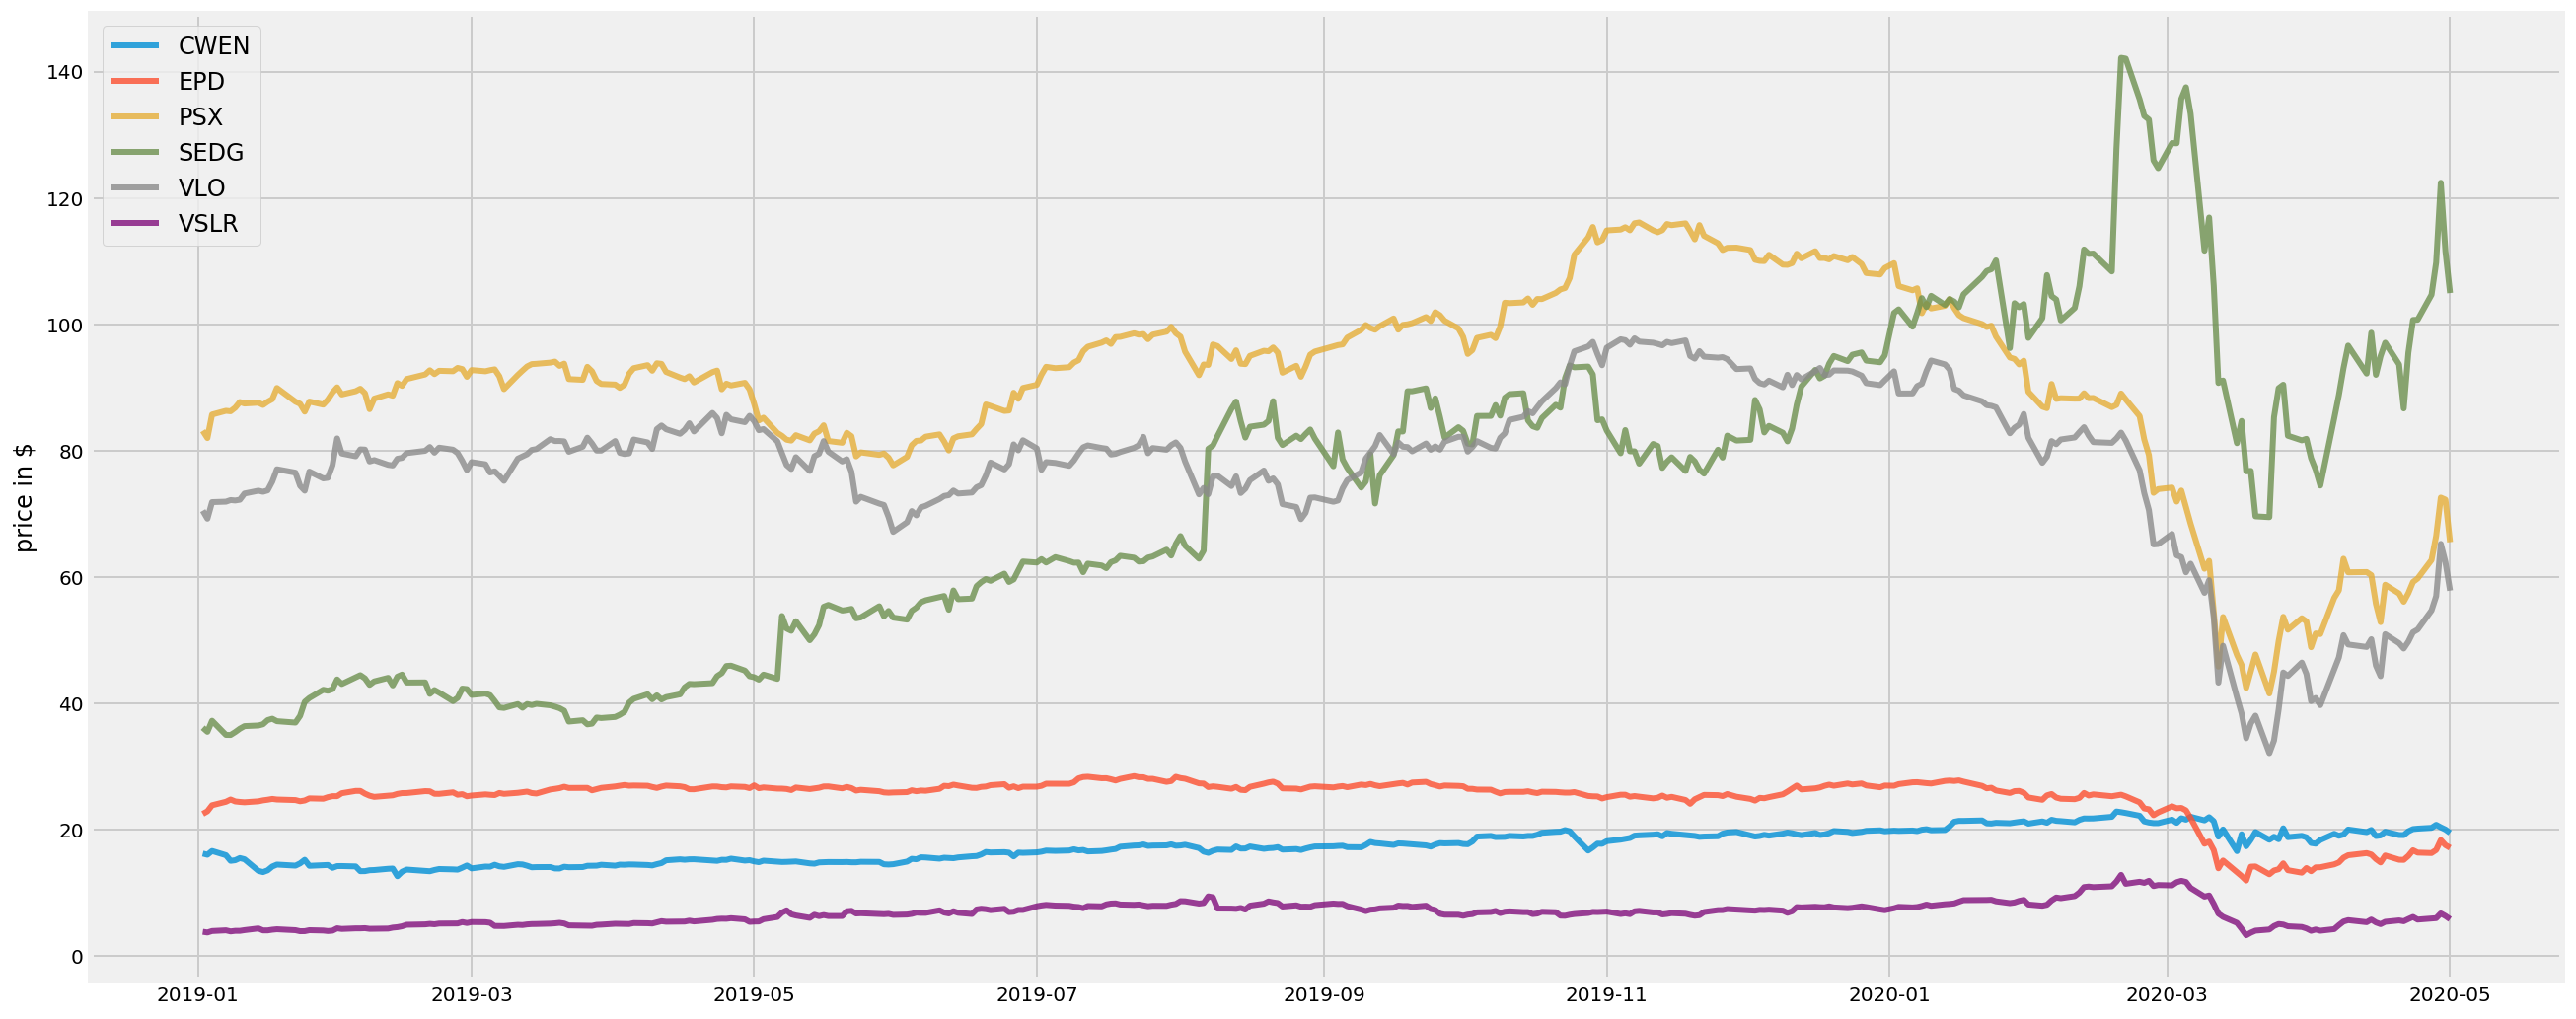

In [14]:
plt.figure(figsize=(20, 9))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

### Simple returns

Text(0, 0.5, 'daily returns')

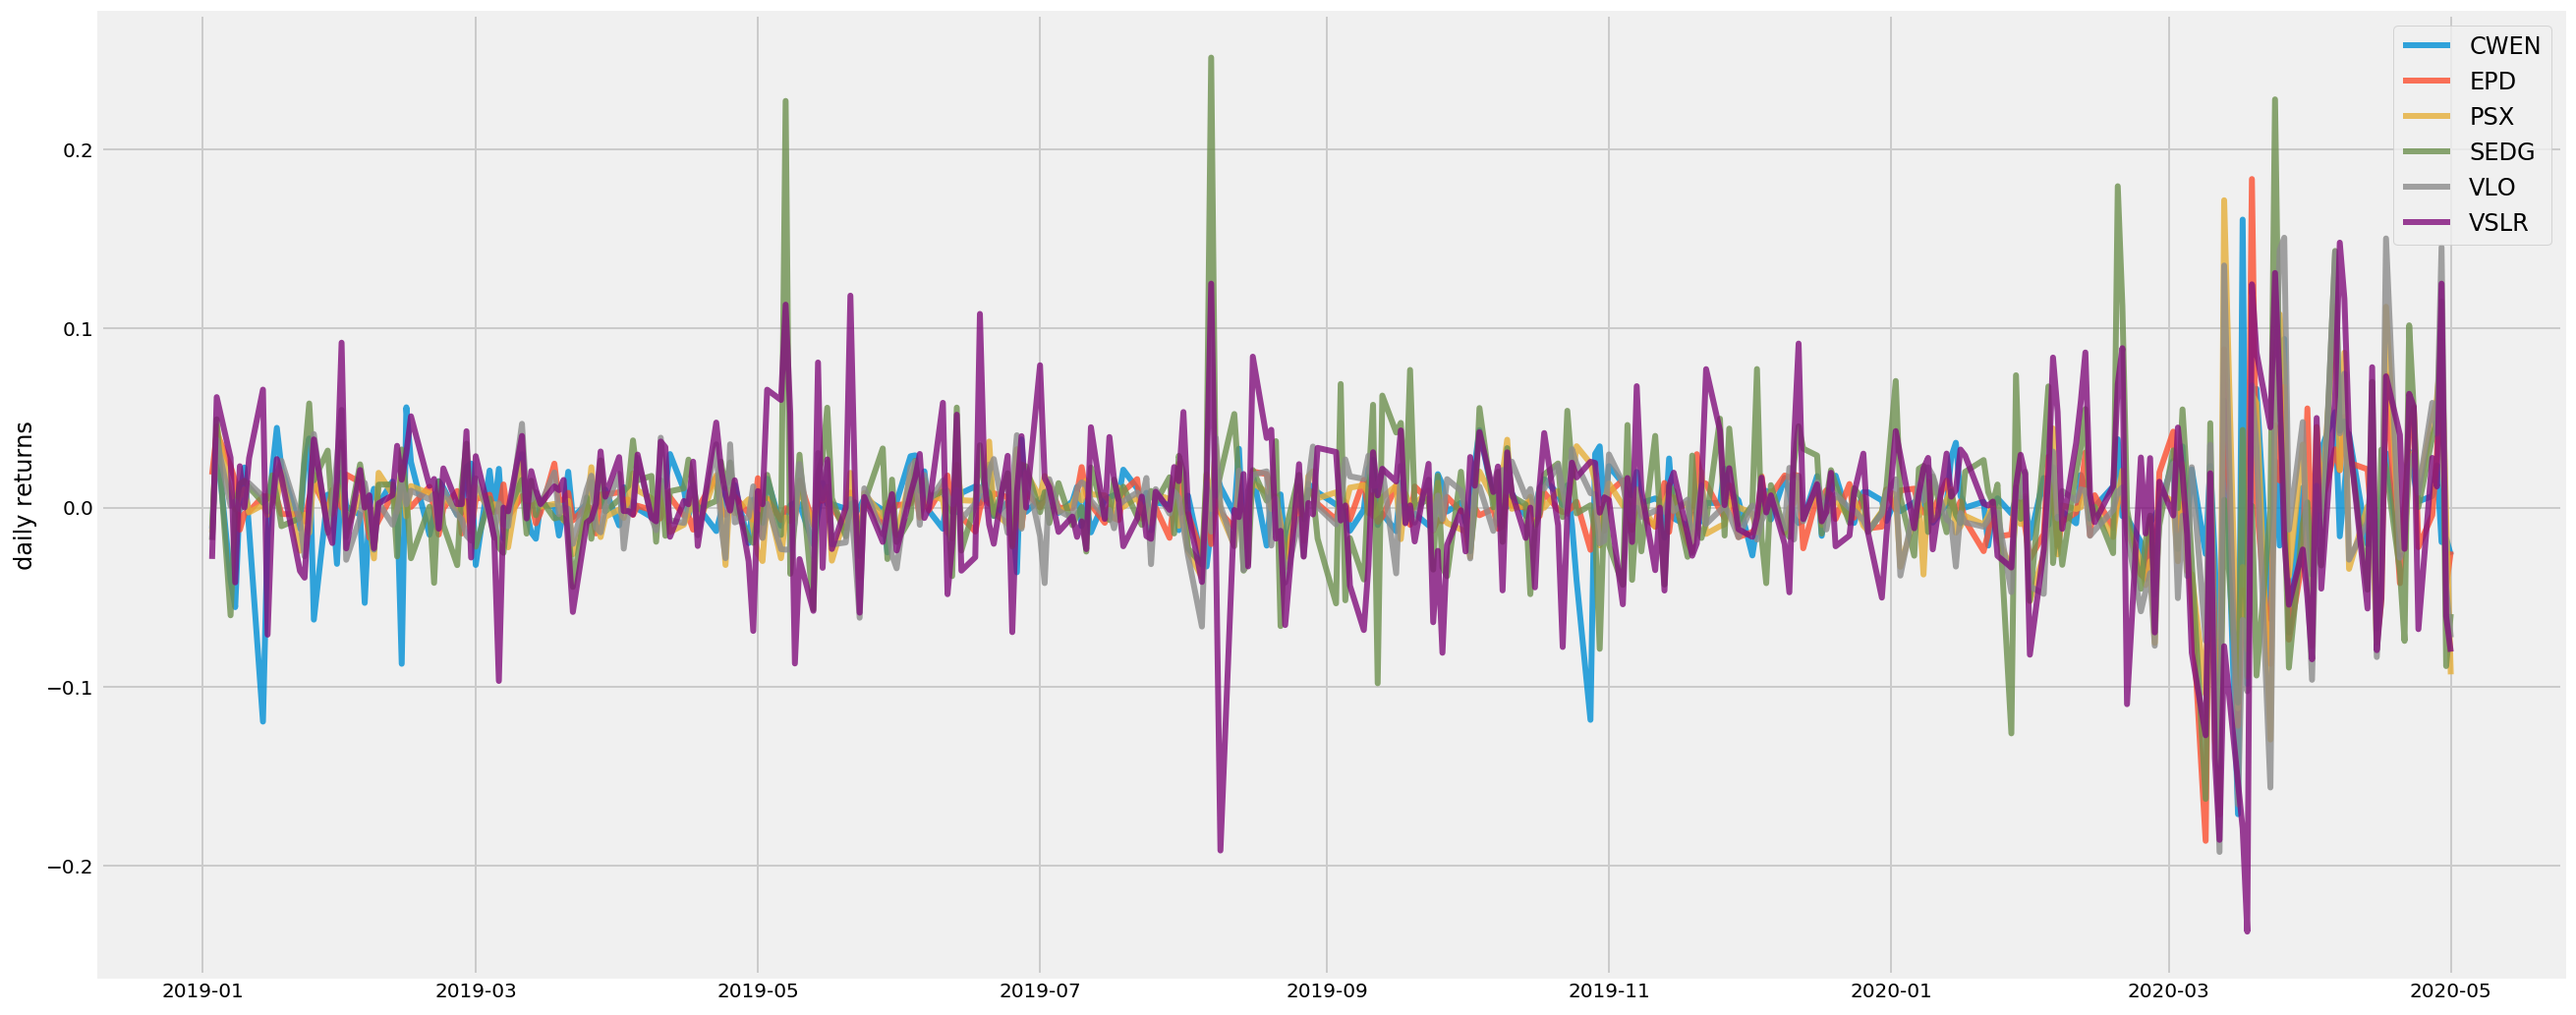

In [15]:
returns = table.pct_change()
plt.figure(figsize=(20, 9))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

### log returns

Text(0, 0.5, 'daily log returns')

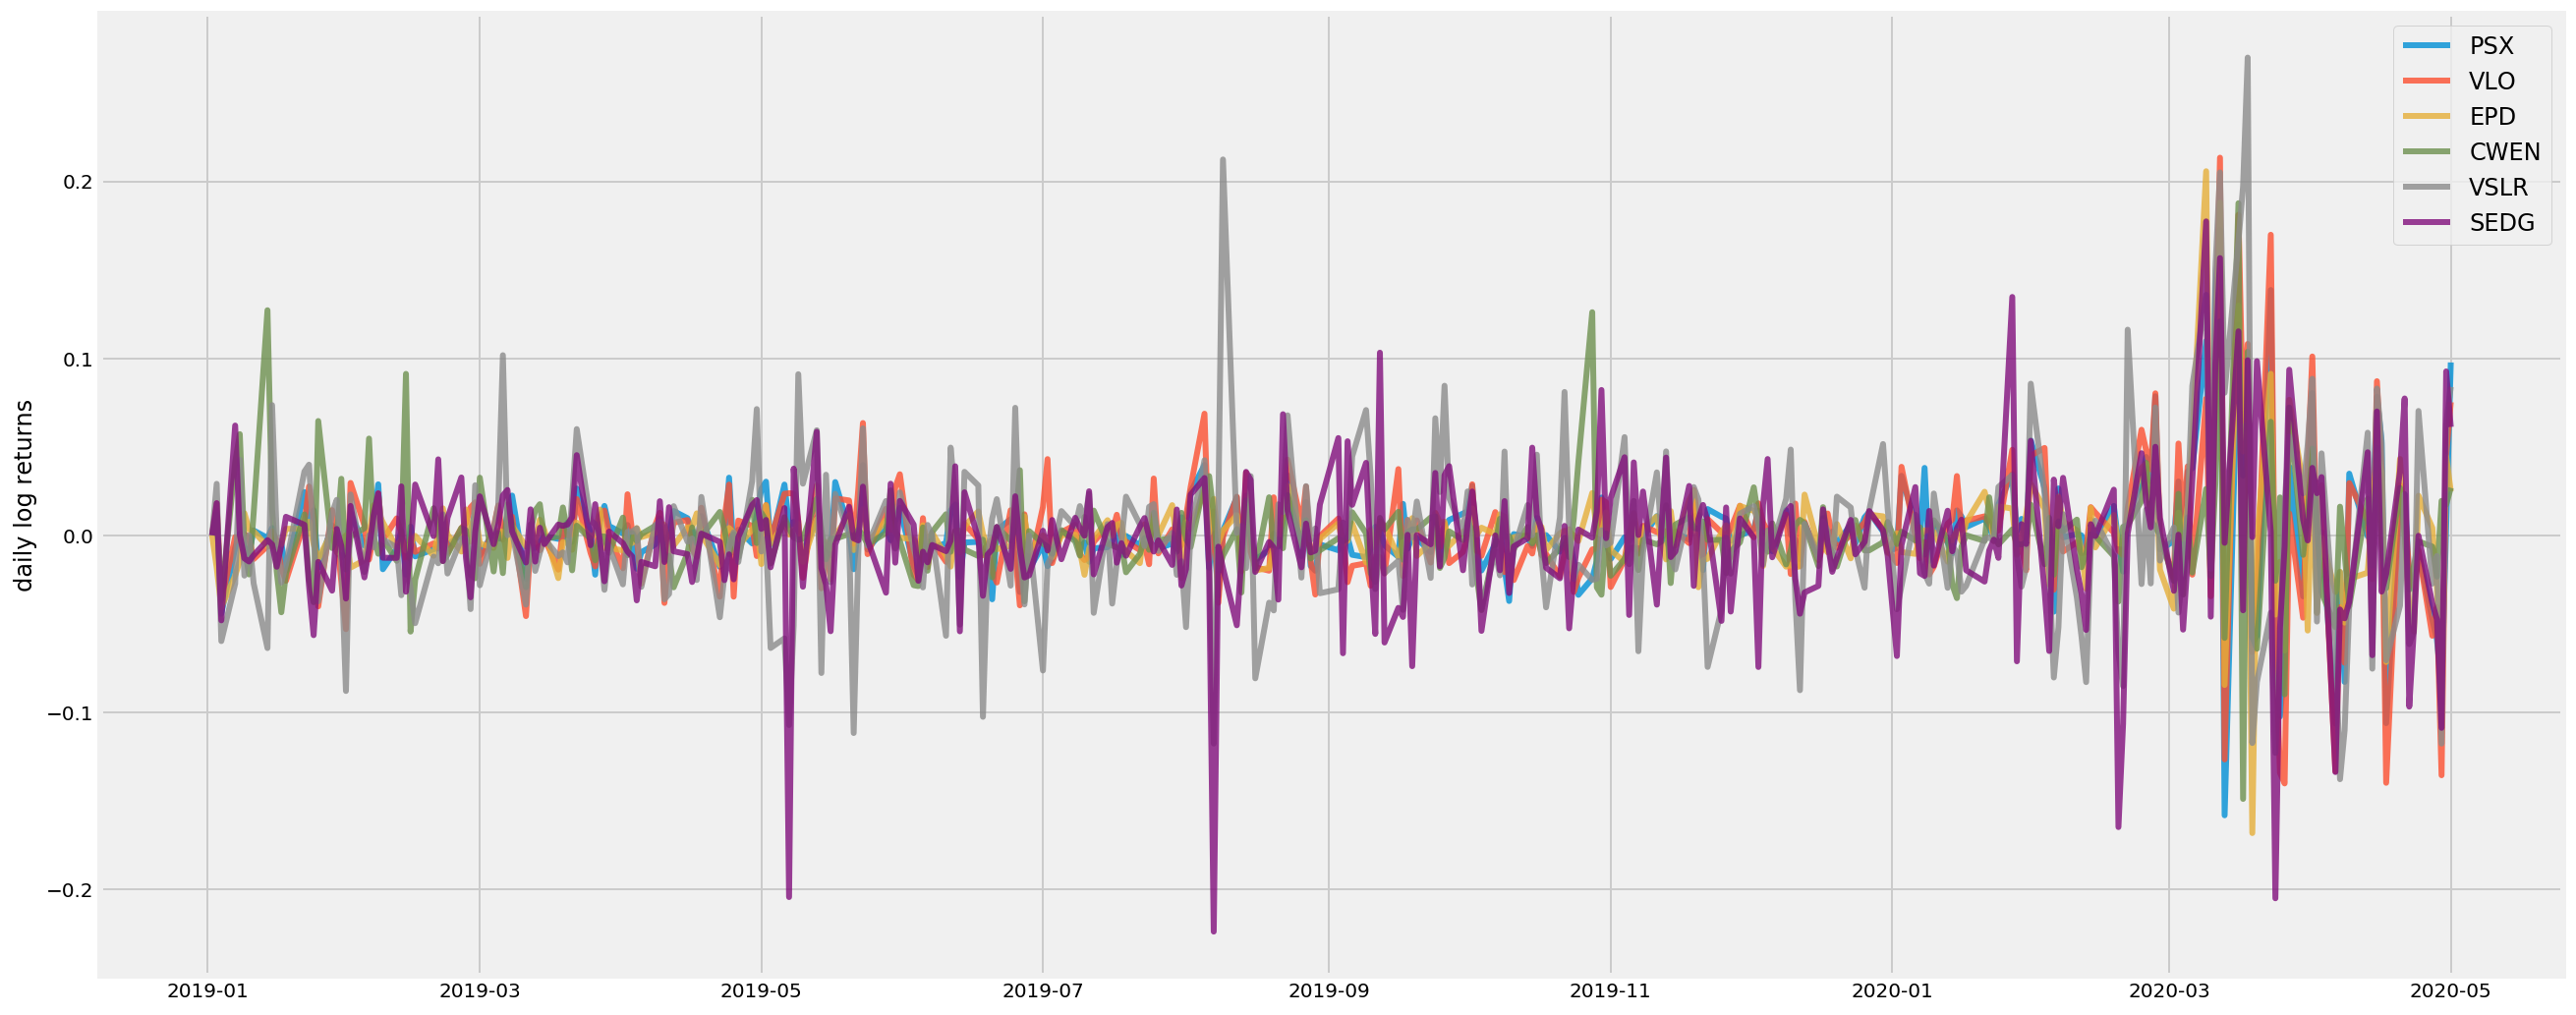

In [16]:
log = pd.DataFrame(columns = energy, index = table.index)

for i in range(len(energy)):
    log_list = []
    for j in range(len(table[energy[i]])):
        if(j+1<len(table[energy[i]])):
            log_returns =  np.log(table[energy[i]][j]) - np.log(table[energy[i]][j+1])
            log_list.append(log_returns)
            

        else:
            None
    log_list.insert(0, 0)   
    log[energy[i]] = log_list


plt.figure(figsize=(20, 9))
for c in log.columns.values:
     plt.plot(log.index, log[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily log returns')


### Normalization to 100

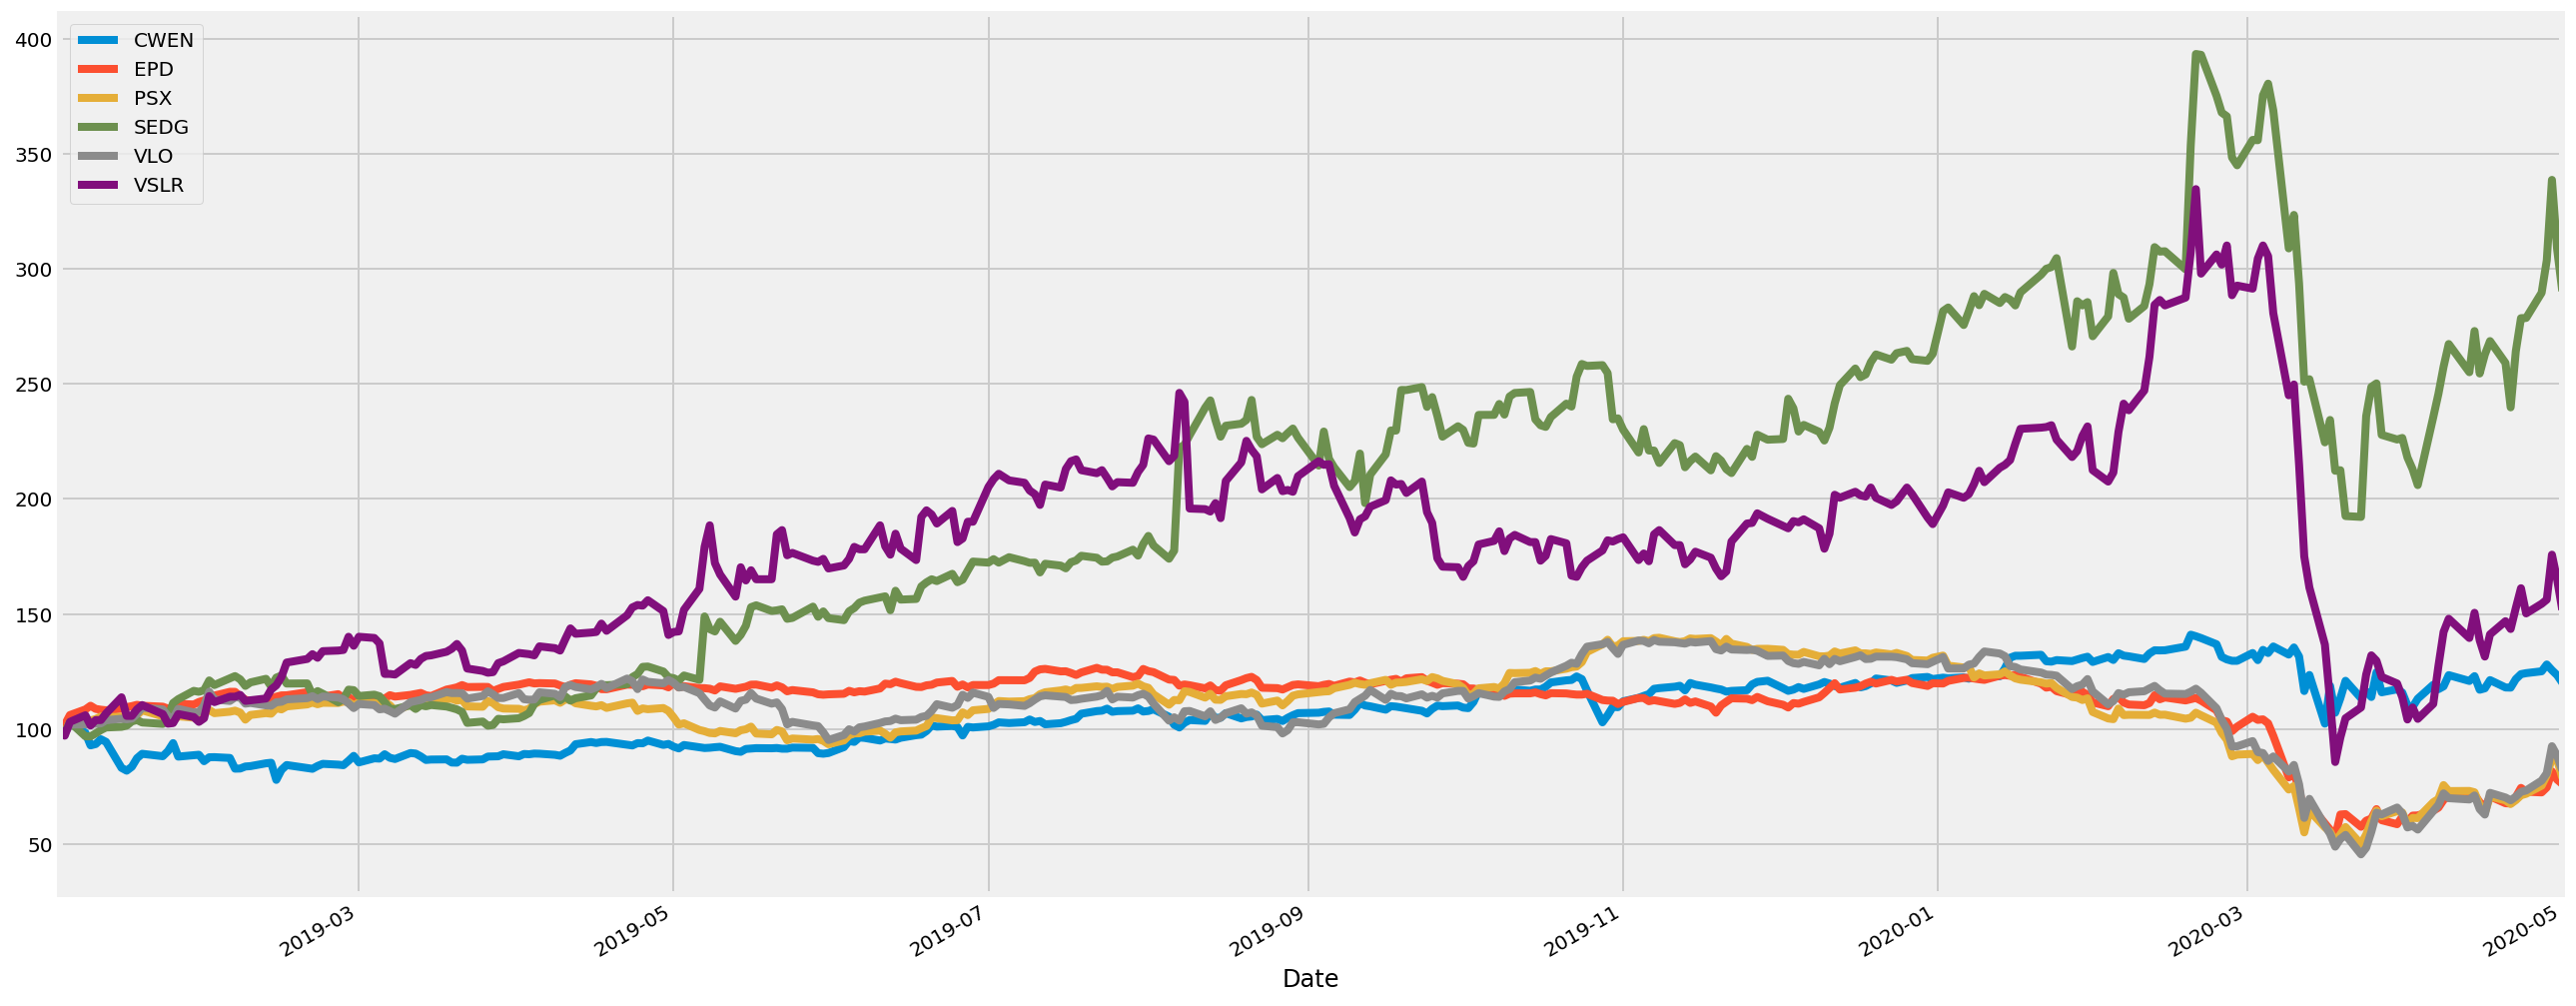

In [17]:
(table/table.iloc[0] * 100).plot(figsize = (20,9))
plt.show()

In [18]:
returns

,CWEN,EPD,PSX,SEDG,VLO,VSLR
Date,,,,,,
2019-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,-0.011628,0.018407,-0.013845,-0.017981,-0.017999,-0.028646
2019-01-04,0.037059,0.041650,0.045339,0.049296,0.037871,0.061662
2019-01-07,-0.040272,0.023010,0.006935,-0.060134,0.001039,0.027778
2019-01-08,-0.055556,0.014749,-0.000875,-0.000286,0.003502,-0.041769
...,...,...,...,...,...,...
2020-04-27,0.006445,-0.004164,0.048901,0.039313,0.058476,0.027730
2020-04-28,0.023645,0.029869,0.060639,0.048715,0.041389,0.011804
2020-04-29,-0.019249,0.093183,0.091476,0.115038,0.145326,0.125000


In [19]:
log.mean()*252

PSX     0.178678
VLO     0.148376
EPD     0.204571
CWEN   -0.137783
VSLR   -0.313158
SEDG   -0.799427
dtype: float64

In [20]:
log.std()*252**0.5

PSX     0.478991
VLO     0.561653
EPD     0.429318
CWEN    0.431495
VSLR    0.784812
SEDG    0.671331
dtype: float64

In [21]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(6)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return(results, weights_record)

mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 50000
risk_free_rate = 0.0073

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print( "Maximum Sharpe Ratio Portfolio Allocation\n")
    print( "Annualised Return:", round(rp,2))
    print( "Annualised Volatility:", round(sdp,2))
    print( "\n")
    print( max_sharpe_allocation)
    print( "-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print( "Annualised Volatility:", round(sdp_min,2))
    print( "\n")
    print( min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.92
Annualised Volatility: 0.62


            CWEN   EPD   PSX   SEDG   VLO  VSLR
allocation  6.79  3.54  0.31  85.62  0.06  3.69
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.11
Annualised Volatility: 0.35


             CWEN    EPD   PSX  SEDG   VLO  VSLR
allocation  48.73  41.35  2.49  3.37  2.15  1.92


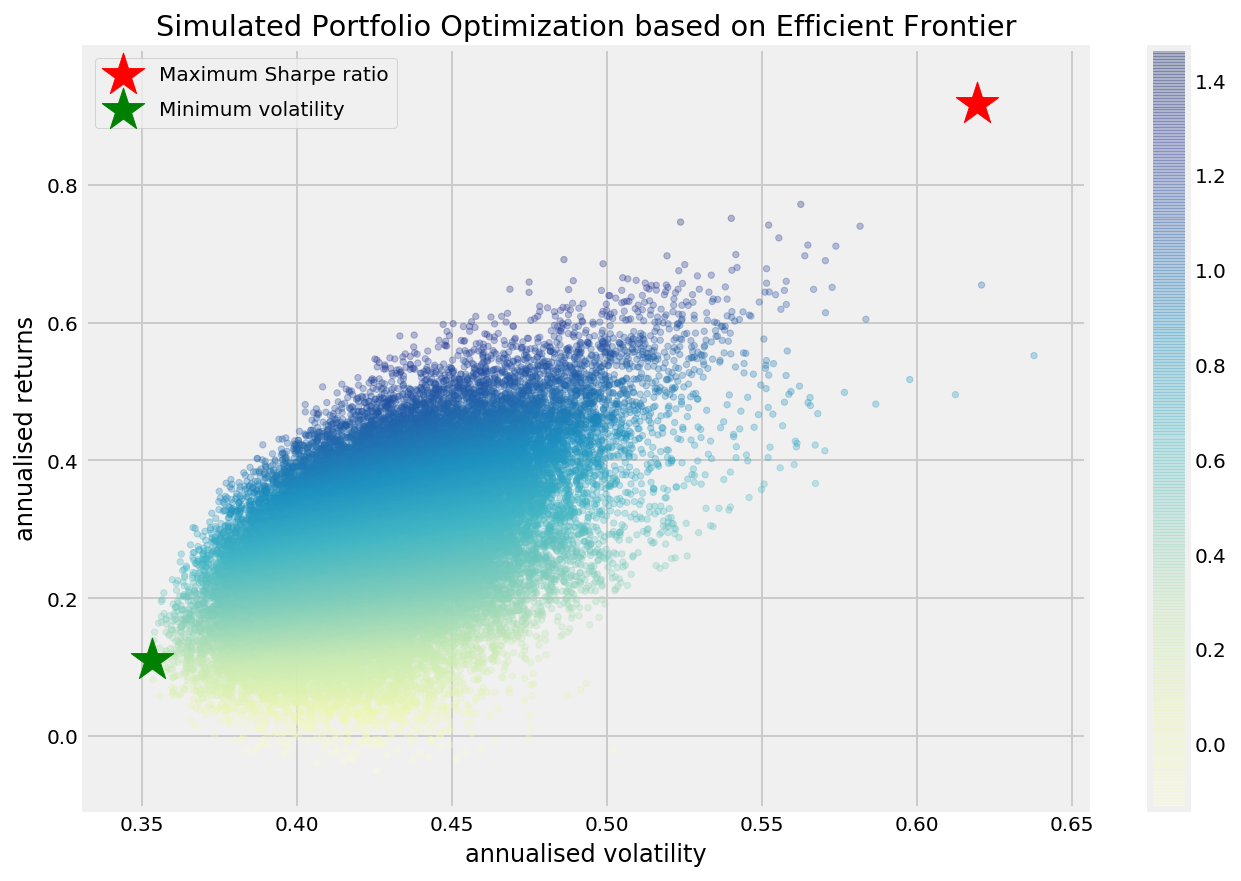

In [22]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)